# JLab May 2019 Lunch Challenge

https://halldweb.jlab.org/talks/ML_lunch/May2019/

## Problems with my model:

At the very bottom, one will see the % error and difference between true and predicted, may be just because it is not trained well, but the difference is fairly large...

## Pre-processing; gathering data

### Retreiving data from site

In [1]:
! mkdir TRAIN
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
! mv images.raw.gz TRAIN
! mv track_parms.csv TRAIN
! mkdir VALIDATION
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/track_parms.csv
! mv images.raw.gz VALIDATION
! mv track_parms.csv VALIDATION

mkdir: cannot create directory ‘TRAIN’: File exists
--2020-10-03 14:30:38--  https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31813265 (30M) [application/x-gzip]
Saving to: ‘images.raw.gz’

images.raw.gz       100%[===================>]  30.34M  15.6MB/s    in 1.9s    

2020-10-03 14:30:40 (15.6 MB/s) - ‘images.raw.gz’ saved [31813265/31813265]

--2020-10-03 14:30:40--  https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38940211 (37M) [text/csv]
Saving to: ‘track_parms.csv’

track_parms.csv     100%[===================>]  37.14M  17.2MB/s    in

### Setting up function to create generator for images

In [2]:
import os
import sys
import gzip
import pandas as pd
import numpy as np
import math

width  = 36
height = 100

# Open labels files so we can get number of samples and pass the
# data frames to the generators later
traindf = pd.read_csv('TRAIN/track_parms.csv')
valdf = pd.read_csv('VALIDATION/track_parms.csv')
STEP_SIZE_TRAIN = len(traindf)/32
STEP_SIZE_VAL = len(valdf)/32

#-----------------------------------------------------
# generate_arrays_from_file
#-----------------------------------------------------
# Create generator to read in images and labels
# (used for both training and validation samples)
def generate_arrays_from_file( labelsdf , dType):

	images_path = dType+'images.raw.gz'
	print( 'generator created for: ' + images_path)

	batch_input           = []
	batch_labels_phi      = []
	batch_labels_z        = []
	idx = 0
	ibatch = 0
	while True:  # loop forever, re-reading images from same file
		with gzip.open(images_path) as f:
			while True: # loop over images in file
			
				# Read in one image
				bytes = f.read(width*height)
				if len(bytes) != (width*height): break # break into outer loop so we can re-open file
				data = np.frombuffer(bytes, dtype='B', count=width*height)
				pixels = np.reshape(data, [width, height, 1], order='F')
				pixels_norm = np.transpose(pixels.astype(np.float) / 255., axes=(1, 0, 2) )
				
				# Labels
				phi = labelsdf.phi[idx]
				z   = labelsdf.z[idx]
				idx += 1

				# Add to batch and check if it is time to yield
				batch_input.append( pixels_norm )
				batch_labels_phi.append( phi )
				batch_labels_z.append( z )
				if len(batch_input) == 32 :
					ibatch += 1
					
					# Since we are training multiple loss functions we must
					# pass the labels back as a dictionary whose keys match
					# the layer their corresponding values are being applied to.
					labels_dict = {
						'phi_output' :  np.array(batch_labels_phi ),
						'z_output'   :  np.array(batch_labels_z   ),		
					}
					
					yield ( np.array(batch_input), labels_dict )
					batch_input      = []
					batch_labels_phi = []
					batch_labels_z   = []

			idx = 0
			f.close()


### All required imports

In [3]:
# import requests
# import gzip
import numpy as np
# import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

## Model building

### Building the model

Begins with one branch and outputs a common 32 node output.  
Then splits into 2, one for phi another for z;
First phi is completed, then concatenated to the z branch.

In [4]:
def buildBranch(input):
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Dense(128,activation='relu')(x)
  
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(32, activation="linear",name="common_out")(x)
  return x

def buildPhiBranch(branch):
  x = keras.layers.Dense(64, activation='relu', name="phi_dense1")(branch)
  x = keras.layers.Dense(128, activation='relu', name="phi_dense2")(x)
  x = keras.layers.Dense(64, activation='relu', name="phi_dense3")(x)
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(x)
  return x

def buildZBranch(branch, arg):
  x = keras.layers.concatenate([branch,arg])
  x = keras.layers.Dense(64, activation='relu', name="z_dense1")(x)
  x = keras.layers.Dense(128, activation='relu', name="z_dense2")(x)
  x = keras.layers.Dense(128, activation='relu', name="z_dense3")(x)
  x = keras.layers.Dense(32, activation='relu', name="z_dense4")(x)
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

inputs = keras.Input(shape=(100, 36, 1))
branch = buildBranch(inputs)
branch_phi = buildPhiBranch(branch)
branch_z = buildZBranch(branch,branch_phi)
model = keras.Model(inputs=inputs, outputs={"phi_output":branch_phi,"z_output":branch_z}, name="detector")
losses = {
    "phi_output":"mse",
    "z_output":"mse"
}
loss_weights = {
    "phi_output":1/10.5,
    "z_output":1/7.5
}
model.compile(optimizer="adam", loss=losses, loss_weights=loss_weights, metrics=["mae"])
# model.compile(optimizer="adam", loss=losses, metrics=["mae"])
model.summary()

Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 36, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 34, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 34, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 98, 34, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

### Create train and validation data generators for the model fit

In [5]:
train_generator = generate_arrays_from_file(traindf,"TRAIN/")
val_generator = generate_arrays_from_file(valdf,"VALIDATION/")

### Fit model and save as "model.keras"

In [6]:
H = model.fit(x=train_generator,
              validation_data=val_generator,
              steps_per_epoch=100,
              validation_steps=20,
              epochs=500,
              verbose=2
)
model.save("model.keras",save_format="h5")

generator created for: TRAIN/images.raw.gz
Epoch 1/500
generator created for: VALIDATION/images.raw.gz
100/100 - 2s - loss: 2.2795 - phi_output_loss: 1.7709 - z_output_loss: 15.8310 - phi_output_mae: 0.7839 - z_output_mae: 3.2699 - val_loss: 5.4030 - val_phi_output_loss: 30.7586 - val_z_output_loss: 18.5521 - val_phi_output_mae: 4.7358 - val_z_output_mae: 3.7499
Epoch 2/500
100/100 - 2s - loss: 1.2435 - phi_output_loss: 0.3945 - z_output_loss: 9.0446 - phi_output_mae: 0.4848 - z_output_mae: 2.2579 - val_loss: 5.5427 - val_phi_output_loss: 32.3563 - val_z_output_loss: 18.4585 - val_phi_output_mae: 4.9693 - val_z_output_mae: 3.7441
Epoch 3/500
100/100 - 2s - loss: 0.8612 - phi_output_loss: 0.2298 - z_output_loss: 6.2949 - phi_output_mae: 0.3717 - z_output_mae: 1.8209 - val_loss: 4.9371 - val_phi_output_loss: 29.0736 - val_z_output_loss: 16.2610 - val_phi_output_mae: 4.6520 - val_z_output_mae: 3.4870
Epoch 4/500
100/100 - 2s - loss: 0.6753 - phi_output_loss: 0.1837 - z_output_loss: 4.9339

## Post processing

### Create graphs to show loss and mae of training and validation data

dict_keys(['loss', 'phi_output_loss', 'z_output_loss', 'phi_output_mae', 'z_output_mae', 'val_loss', 'val_phi_output_loss', 'val_z_output_loss', 'val_phi_output_mae', 'val_z_output_mae'])


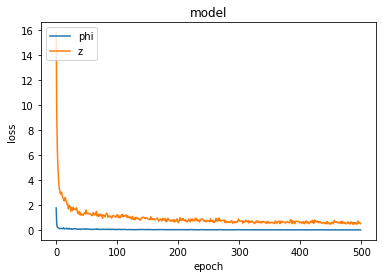

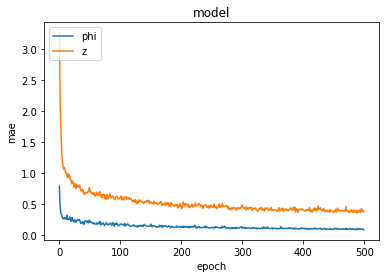

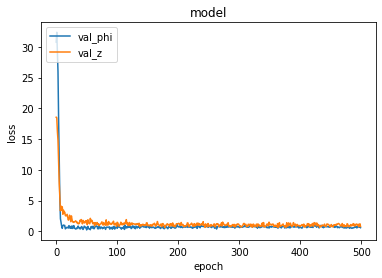

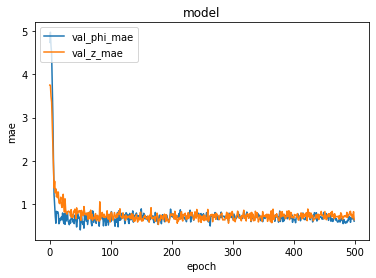

In [7]:
print(H.history.keys())
try:
  plt.plot(H.history['phi_output_loss'])
  plt.plot(H.history['z_output_loss'])
  plt.title('model')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['phi','z'],loc='upper left')
  plt.show()

  plt.plot(H.history['phi_output_mae'])
  plt.plot(H.history['z_output_mae'])
  plt.title('model')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['phi','z'],loc='upper left')
  plt.show()


  plt.plot(H.history['val_phi_output_loss'])
  plt.plot(H.history['val_z_output_loss'])
  plt.title('model')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['val_phi','val_z'],loc='upper left')
  plt.show()

  plt.plot(H.history['val_phi_output_mae'])
  plt.plot(H.history['val_z_output_mae'])
  plt.title('model')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['val_phi_mae','val_z_mae'],loc='upper left')
  plt.show()
except e:
  print("error:")
  print(e)

### Create test data generator and clear arrays used for histograms


In [8]:
test_generator = generate_arrays_from_file(valdf,"VALIDATION/")
diff_phi = np.array([])
diff_phi_err = np.array([])
diff_z = np.array([])
diff_z_err = np.array([])

### Graph histograms of test data

generator created for: VALIDATION/images.raw.gz
1/1 [==============================] - 0s 4ms/step


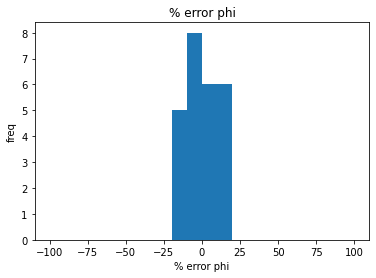

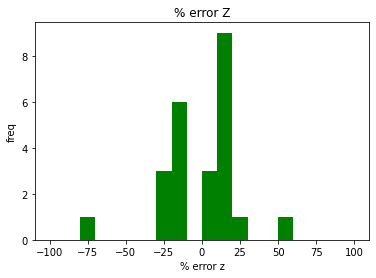

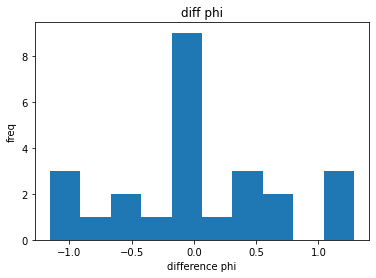

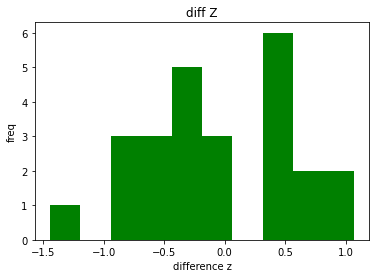

In [9]:
ev = model.evaluate(test_generator,steps=100,batch_size=32)

test = next(test_generator)
test = np.array(test)
test_x = test[0]
test_y = test[1]

pred = model.predict(x=test_x,verbose=1)

prt = False

# diff_phi = []
# diff_phi_err = []
# diff_z = []
# diff_z_err = []

if prt: print("phi:::\n")
for i in range(25):
  true = np.reshape(test_y["phi_output"],[32,1])[i]
  exp = pred["phi_output"][i]

  # diff_phi.append(exp-true)
  # diff_phi_err.append((abs(exp-true)/true)*100)
  diff_phi = np.append(diff_phi,exp-true)
  diff_phi_err = np.append(diff_phi_err,((abs(exp-true)/true)*100))

  if prt: print(exp," : ",true," : ",diff_phi[-1])

if prt: print("\n\nz::::\n")
for i in range(25):
  true = np.reshape(test_y["z_output"],[32,1])[i]
  exp = pred["z_output"][i]

  # diff_z.append(exp-true)
  # diff_z_err.append((abs(exp-true)/true)*100)
  diff_z = np.append(diff_z,exp-true)
  diff_z_err = np.append(diff_z_err,((abs(exp-true)/true)*100))

  if prt: print(exp," : ",true," : ",diff_z[-1])
  
diff_phi = np.array(diff_phi)
diff_z = np.array(diff_z)
diff_phi_err = np.array(diff_phi_err)
diff_z_err = np.array(diff_z_err)


# plt.hist(diff_phi,10)
plt.hist(diff_phi_err,20,[-100,100])
plt.title('% error phi')
plt.ylabel('freq')
plt.xlabel('% error phi')
plt.show()

# plt.hist(diff_z,10)
plt.hist(diff_z_err,20,[-100,100],color='g')
plt.title('% error Z')
plt.ylabel('freq')
plt.xlabel('% error z')
plt.show()


plt.hist(diff_phi,10)
plt.title('diff phi')
plt.ylabel('freq')
plt.xlabel('difference phi')
plt.show()

plt.hist(diff_z,10,color='g')
plt.title('diff Z')
plt.ylabel('freq')
plt.xlabel('difference z')
plt.show()